# NEURAL NETWORKS AND DEEP LEARNING PROJECT

---
A.A. 2023/24 (6 CFU) - Giuseppe Labate, Sana Amiri
---

## Project 1 - Car classification, attribute prediction and car verification

In this project 

1.   **Classification** car images given cars dataset CompCars.

2.   **Attributes prediction** based on the images.  
        Attributes for this project are:  
    1. Explicit Attributes:  
    	1. Number of doors  
    	2. Number of seats  
    	3. Type of car  
	2. Implicit Attributes:  
    	4. Max speed  
    	5. Displacement  


In [1]:
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
# %matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
# sns.set()  ---> Uncomment if you want to use seaborn themes

## tqdm for loading bars
from tqdm.notebook import tqdm
import os
import random
## NumPy
import numpy as np
## PyTorch
import torch
import torch.nn as nnpo
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import scipy.io

## Torchvision
import torchvision   # For Computer Vision tasks
from torchvision import transforms   # Transforms for images for data augmentation


# Path to the folder where the datasets are/should be downloaded
DATA_PATH = os.path.join(".", "Deep_Project", "data")  # Change this path to your desired location

NUM_WORKERS = 0 #os.cpu_count()

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

C:\Users\giuse\AppData\Local\Temp\ipykernel_26916\4284118634.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Device: cuda:0
Number of workers: 0


<Figure size 640x480 with 0 Axes>

In [2]:
# import torchvision.models as models
# from torchvision.models import ResNet50_Weights

# # Carica un modello pre-addestrato su ImageNet
# model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# # Metti il modello in modalità di valutazione
# model.eval()

In the following cell, I will create a transformation composition that will be applied to the images in our dataset. This transformation is crucial for preprocessing the images before they are fed into our machine learning model. The preprocessing steps may include operations such as resizing, normalization, augmentation, and other techniques to enhance the quality and variability of the training data. By applying these transformations, we aim to improve the model's performance and generalization capabilities. Let's proceed with defining this transformation function in the next cell.

In [3]:
transform = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In the next code snippet, we will perform DataLoading of the dataset contained in `./Deep_Project/data`. The dataset will be split according to the splitting files located in the `train_test_split` folder.

FROM HERE THE CODE IS USED TO CROP THE DATASET AND LOAD IT CORRECTLY WITH THE RIGHT LABEL


In [4]:
####MODIFICA ALLA FUNZIONE SAVE_CROP_IMAGES###
#HERE THE FUNCTION HAS TO SAVE THE IMAGES IN THE FOLDER CROPPED_IMAGES/DIRECTORY OF THE FULL IMAGE
#FOR EXAMPLE, IF THE FULL IMAGE IS IN THE FOLDER "image/AM General Hummer SUV 2000" THE CROPPED IMAGE HAS TO BE SAVED IN "cropped_images/classification/train/AM General Hummer SUV 2000"
#WE WANT ALSO TO DO IT WITHOUT USING CROPDATASET FUNCTION

from PIL import Image
import torchvision.transforms as transforms

# Path to the folder where the datasets are/should be downloaded
image_dir = os.path.join(DATA_PATH, "image")
label_dir = os.path.join(DATA_PATH, "label")
train_list = os.path.join(DATA_PATH, "train_test_split", "classification", "train.txt")
test_list = os.path.join(DATA_PATH, "train_test_split", "classification", "test.txt")

def crop_image(image, bbox):
	x1, y1, x2, y2 = bbox
	image_np = np.array(image)
	return image_np[y1:y2, x1:x2]

#Loads the viewpoint and bounding box from the label file
def load_label(label_path):
	with open(label_path, 'r') as f:
		lines = f.readlines()
		viewpoint = int(lines[0].strip())
		bbox = list(map(int, lines[2].strip().split()))
	return viewpoint, bbox

def save_cropped_images(file_list, output_dir):
	# Create the output directory if it does not exist
	if not os.path.exists(output_dir):
		os.makedirs(output_dir)

		# Access to the image paths and labels
		with open(file_list, 'r') as f:
			for line in tqdm(f, desc="Saving images"):
				image_path = os.path.join(image_dir, line.strip())
				label_path = os.path.join(label_dir, line.strip()).replace('.jpg', '.txt')
				car_properties = load_label(label_path)
				# Dividing the label path into car make, model and year
				label_path_parts = line.strip().split('/')

				# Given the values of labels path, put the correct car make, model and year in the output directory
				output_image_dir = os.path.join(output_dir, label_path_parts[0], label_path_parts[1], label_path_parts[2])
				os.makedirs(output_image_dir, exist_ok=True)

				# Load the image
				image = Image.open(image_path).convert("RGB")

				# Crop the image
				cropped_image = crop_image(image, car_properties[1])
				cropped_image = transforms.ToPILImage()(cropped_image)

				# Save the cropped image
				output_image_path = os.path.join(output_image_dir, os.path.basename(image_path))
				cropped_image.save(output_image_path)

def get_names(mat_file, labels):
	# Load the make and model names from the .mat file
	mat_data = scipy.io.loadmat(mat_file)
	make_names = mat_data['make_names']
	model_names = mat_data['model_names']
	make_name = make_names[int(labels[0]) - 1][0].item()
	model_name = model_names[int(labels[1]) - 1][0].item()
	return make_name, model_name

# Example usage
output_dir = os.path.join(DATA_PATH, "cropped_image", "classification")
train_path = os.path.join(output_dir, "train")

test_path = os.path.join(output_dir, "test")
print("test", test_path)
print("train", train_path)
save_cropped_images(train_list, train_path)
save_cropped_images(test_list, test_path)


test .\Deep_Project\data\cropped_image\classification\test
train .\Deep_Project\data\cropped_image\classification\train


In [5]:
#### DATA LOADER FOR CROPPED IMAGES ####
from torch.utils.data import Dataset, DataLoader

class CroppedCarDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform

		# Save the images contained in image_dir
        self.image_paths = []
        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.endswith(".jpg"):
                    self.image_paths.append(os.path.join(root, file))

		# Save the labels
        self.car_make = []
        self.car_model = []
        for image_path in self.image_paths:
            label = image_path.split(os.sep)[-4:-1]  # Car make, model, year
            #Get labels from the image path, append them to the lists, and convert them to tensors of type long
            self.car_make.append(int(label[0]))
            self.car_model.append(int(label[1]))

		# # Load the make and model names from the .mat file
        # mat_data = scipy.io.loadmat(mat_file)
        # self.make_names = mat_data['make_names']
        # self.model_names = mat_data['model_names']

	#Returns the image, viewpoint, bounding box and label path
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")

        # make_name = self.make_names[int(labels[0]) - 1][0].item()
        # model_name = self.model_names[int(labels[1]) - 1][0].item()
        # year = labels[2]

        #label = [make_name, model_name, year]
        car_make = self.car_make[index]
        car_model = self.car_model[index]

        if self.transform:
            image = self.transform(image)

        return image, car_make, car_model

    def __len__(self):
        return len(self.image_paths)

print("Data loading is complete.")



Data loading is complete.


In [6]:
# Path to the folder where the datasets are/should be downloaded
class_dir = os.path.join(DATA_PATH, "cropped_image", "classification")
train_dir = os.path.join(class_dir, "train")
test_dir = os.path.join(class_dir, "test")
mat_file = os.path.join(DATA_PATH, "misc" ,"make_model_name.mat")

# Create the datasets
train_val_dataset = CroppedCarDataset(image_dir=train_dir, transform=transform) #dataset that contains train and validation datasets

train_len = int(0.7*len(train_val_dataset))  # 70% training
val_len = len(train_val_dataset) - train_len	# 30% validation

train_dataset, val_dataset = data.random_split(train_val_dataset, [train_len, val_len])

test_dataset = CroppedCarDataset(image_dir=test_dir, transform=transform)   #dataset that contains test dataset



# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

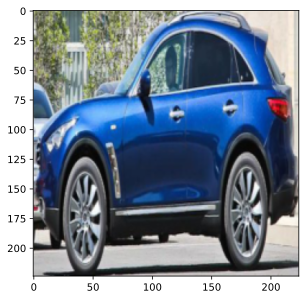

Make: 131
Model: 1015
('Infiniti', 'Infiniti QX70')
Number of images in the training set: 11211
Number of images in the validation set: 4805
Number of images in the test set: 14939
Image shape: torch.Size([3, 224, 224])


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Function to denormalize images
def denormalize(img, mean, std):
    img = img.clone()  # Create a copy of the image
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # Denormalize
    return img

# Function to display images
def imshow(img):
    #img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Mean and std used for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Display the first 5 images from the training set
# for i in range(5):
#     img, label = train_dataset[i]
#     img = denormalize(img, mean, std)
#     imshow(img)
#     print("Labels:",label)

img, car_make, car_model = val_dataset[2000]
img = denormalize(img, mean, std)
imshow(img)
print("Make:",car_make)
print("Model:",car_model)

print(get_names(mat_file, [car_make, car_model]))

print("Number of images in the training set:", len(train_dataset))
print("Number of images in the validation set:", len(val_dataset))
print("Number of images in the test set:", len(test_dataset))
print("Image shape:", img.shape)

# Model

Let's create the models we will use.  
In this project we will train and test 3 different models to see which one is better:  
##### 1. ImageNet pretrained Network
##### 2. ResNet50
##### 3. Inception v4

Number of features: 2048
Epoch 0/24
----------


c:\Users\giuse\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 3.4441 Acc: 0.1818


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.4653 Acc: 0.2000

Epoch 1/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 2.3091 Acc: 0.4545


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 3.1156 Acc: 0.4000

Epoch 2/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 3.0971 Acc: 0.1818


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.8592 Acc: 0.4000

Epoch 3/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 2.3466 Acc: 0.1818


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.7734 Acc: 0.0000

Epoch 4/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.9845 Acc: 0.4545


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 3.0156 Acc: 0.2000

Epoch 5/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.7539 Acc: 0.4545


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.6277 Acc: 0.0000

Epoch 6/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.3729 Acc: 0.5455


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.2078 Acc: 0.4000

Epoch 7/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 2.0215 Acc: 0.6364


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.4097 Acc: 0.2000

Epoch 8/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.4417 Acc: 0.6364


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.8647 Acc: 0.0000

Epoch 9/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 3.1351 Acc: 0.1818


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.5425 Acc: 0.2000

Epoch 10/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 2.3765 Acc: 0.3636


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.4127 Acc: 0.2000

Epoch 11/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.7985 Acc: 0.6364


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.2515 Acc: 0.4000

Epoch 12/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.6952 Acc: 0.6364


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 1.9027 Acc: 0.6000

Epoch 13/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.3948 Acc: 0.5455


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 1.9504 Acc: 0.4000

Epoch 14/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.9989 Acc: 0.5455


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.2630 Acc: 0.2000

Epoch 15/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.1104 Acc: 0.8182


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.3573 Acc: 0.0000

Epoch 16/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.5114 Acc: 0.5455


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.1473 Acc: 0.0000

Epoch 17/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.8853 Acc: 0.2727


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.5672 Acc: 0.4000

Epoch 18/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.5793 Acc: 0.4545


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.3985 Acc: 0.0000

Epoch 19/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.8226 Acc: 0.5455


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.1506 Acc: 0.0000

Epoch 20/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.4493 Acc: 0.8182


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 1.6020 Acc: 0.4000

Epoch 21/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 2.3955 Acc: 0.2727


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.5238 Acc: 0.0000

Epoch 22/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.6560 Acc: 0.4545


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.2378 Acc: 0.2000

Epoch 23/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.2214 Acc: 0.7273


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.0125 Acc: 0.4000

Epoch 24/24
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 1.5473 Acc: 0.6364


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.4034 Acc: 0.4000

Best val Acc: 0.014093


Evaluation:   0%|          | 0/467 [00:00<?, ?it/s]

Loss: 0.0072 Acc: 0.0000


C:\Users\giuse\AppData\Local\Temp\ipykernel_26916\689202386.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(DATA_PATH, "r

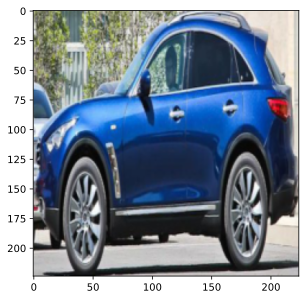

Make: 131
Model: 1015
('Infiniti', 'Infiniti QX70')


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\giuse\\OneDrive - Università degli Studi di Padova\\Uni\\5° anno\\Secondo Semestre\\Neural Networks and Deep Learning\\Labs\\FINAL_project\\Deep_Project\\data\\cropped_image\\classification\\test'

In [8]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights

MODELS_NUM = 431
MAKE_NUM = 163

car_make_bool = True   ## TODO Remove this line

# Upload a pre-trained model to ImageNet
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Freeze all the layers in the network
for param in model.parameters():
	param.requires_grad = False

# Get the number of features in the model
num_features = model.fc.in_features
print("Number of features:", num_features)
# Replace the final layer with a fully connected layer with the number of features in the model
if car_make_bool:
	model.fc = nnpo.Linear(num_features, MAKE_NUM)
else:
	model.fc = nnpo.Linear(num_features, MODELS_NUM)

# Move the model to the device
model = model.to(device)

# Define the loss function
criterion = nnpo.CrossEntropyLoss()
criterion = criterion.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Function to calculate the accuracy of the model
def accuracy(outputs, labels):
	_, preds = torch.max(outputs, dim=1)
	return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Function to train the model
def train_model(model, train_dataloader ,criterion, optimizer, scheduler, num_epochs=25):
	best_model_wts = None
	best_acc = 0.0

	for epoch in range(num_epochs):
		print('Epoch {}/{}'.format(epoch, num_epochs - 1))
		print('-' * 10)

		# Each epoch has a training and validation phase
		for phase in ['train', 'val']:
			if phase == 'train':
				model.train()  # Set model to training mode
				dataloader = train_loader
			else:
				model.eval()   # Set model to evaluation mode
				dataloader = val_loader

			running_loss = 0.0
			running_corrects = 0

			# Iterate over data
			iterator = tqdm(dataloader, desc=phase)
			for batch_x, batch_car_make, batch_car_model in iterator:
				batch_x = batch_x.to(device)
				if car_make_bool:
					labels = batch_car_make.to(device)
				else:
					labels = batch_car_model.to(device)

				# Zero the parameter gradients
				optimizer.zero_grad()

				# Forward pass
				with torch.set_grad_enabled(phase == 'train'):
					outputs = model(batch_x)
					loss = criterion(outputs, labels)

					# Backward pass + optimize only if in training phase
					if phase == 'train':
						loss.backward()
						optimizer.step()

				# Statistics
				running_loss += loss.item() * batch_x.size(0)
				running_corrects += accuracy(outputs, labels)

			if phase == 'train':
				train_loss = running_loss / len(train_dataset)
				train_acc = running_corrects.double() / len(train_dataset)
			else:
				val_loss = running_loss / len(val_dataset)
				val_acc = running_corrects.double() / len(val_dataset)

				# Update the learning rate
				scheduler.step(val_loss)

				# Save the best model
				if val_acc > best_acc:
					best_acc = val_acc
					best_model_wts = model.state_dict()

			print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, loss, accuracy(outputs, labels)))

		print()

	print('Best val Acc: {:4f}'.format(best_acc))

	# Load the best model weights
	model.load_state_dict(best_model_wts)

	return model

# Train the model
model = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=25)

# Save the model
torch.save(model.state_dict(), os.path.join(DATA_PATH, "resnet50_classification.pth"))

# Function to evaluate the model
def evaluate_model(model, dataloader):
	model.eval()
	running_loss = 0.0
	running_corrects = 0

	iterator = tqdm(dataloader, desc="Evaluation")
	# Iterate over data
	for batch_x, batch_car_make, batch_car_model in iterator:
		batch_x = batch_x.to(device)
		if car_make_bool:
			labels = batch_car_make.to(device)
		else:
			labels = batch_car_model.to(device)

		# Forward pass
		with torch.no_grad():
			outputs = model(batch_x)
			loss = criterion(outputs, labels)

		# Statistics
	running_loss += loss.item() * batch_x.size(0)
	running_corrects += accuracy(outputs, labels)

	epoch_loss = running_loss / len(dataloader.dataset)
	epoch_acc = running_corrects.double() / len(dataloader.dataset)

	print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

# Evaluate the model on the test set
evaluate_model(model, test_loader)

# Function to predict the class of an image
def predict_image(image_path, model, transform):
	image = Image.open(image_path).convert("RGB")
	image = transform(image).unsqueeze(0).to(device)
	outputs = model(image)
	_, preds = torch.max(outputs, 1)
	return preds.item()

# Load the model
model.load_state_dict(torch.load(os.path.join(DATA_PATH, "resnet50_classification.pth")))
model.eval()

# Predict the class of an image
image_path = os.path.join(test_dir, )

# Load the image
img, car_make, car_model = val_dataset[2000]
img = denormalize(img, mean, std)
imshow(img)
print("Make:",car_make)
print("Model:",car_model)

print(get_names(mat_file, [car_make, car_model]))

# Predict the class of the image
pred = model(img.unsqueeze(0).to(device)).argmax().item()
print("Prediction:", pred)


